Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Rozdział 18. Uczenie przez wzmacnianie jako mechanizm podejmowania decyzji w skomplikowanych środowiskach

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-05 

numpy 1.17.3
scipy 1.3.1
matplotlib 3.1.1
tensorflow 2.0.0
tensorflow_datasets 1.2.0


In [1]:
from IPython.display import Image
%matplotlib inline

# Wprowadzenie: uczenie z doświadczenia

## Filozofia uczenia przez wzmacnianie

## Definicja interfejsu agent-środowisko w systemie uczenia przez wzmacnianie

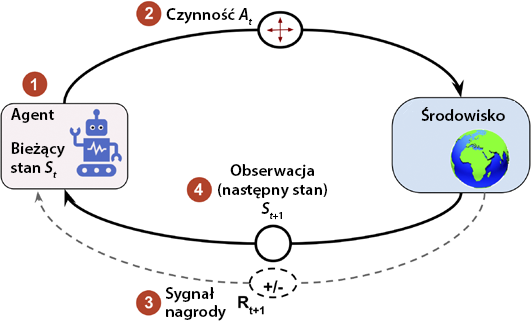

In [2]:
Image(filename='rysunki/18_01.png', width=700)

## Wyjaśnienie matematyczne procesów decyzyjnych Markowa

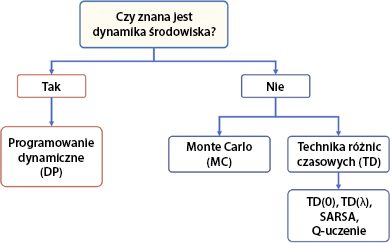

In [3]:
Image(filename='rysunki/18_02.png', width=700)

## Wizualizacja procesu Markowa

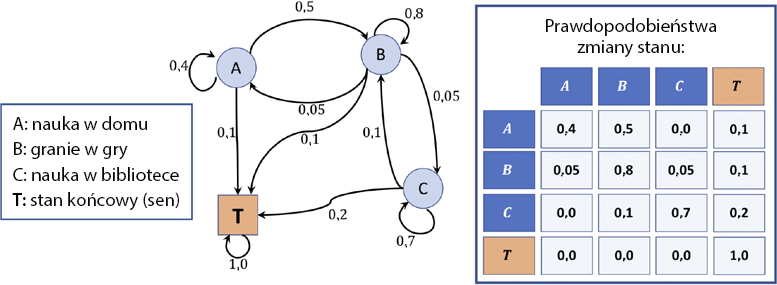

In [4]:
Image(filename='rysunki/18_03.png', width=700)

## Zadania epizodyczne a zadania ciągłe

## Terminologia uczenia przez wzmacnianie: zwrot, strategia i funkcja wartości

### Zwrot

* **Intuicyjne postrzeganie współczynnika dyskontowego**

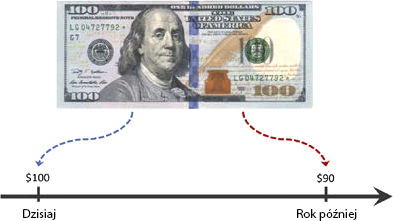

In [5]:
# Intuicyjne postrzeganie współczynnika dyskontowego

Image(filename='rysunki/18_04.png', width=700)

### Strategia

### Funkcja wartości



## Programowanie dynamiczne za pomocą równania Bellmana

# Algorytmy uczenia przez wzmacnianie

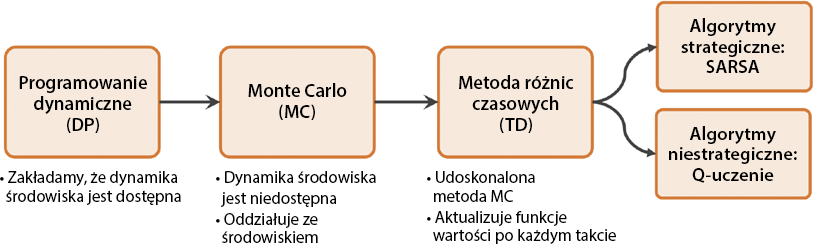

In [6]:
Image(filename='rysunki/18_05.png', width=700)

## Programowanie dynamiczne

### Ocena strategii: przewidywanie funkcji wartości za pomocą programowania dynamicznego

### Usprawnianie strategii za pomocą oszacowanej funkcji wartości

### Iteracja strategii

### Iteracja wartości

## Uczenie przez wzmacnianie metodą Monte Carlo

### Oszacowanie funkcji wartości stanu metodą Monte Carlo

### Oszacowanie funkcji wartości czynności metodą Monte Carlo

### Wyszukiwanie optymalnej strategii za pomocą sterowania Monte Carlo

### Usprawnianie strategii: obliczanie strategii zachłannej z funkcji wartości czynności 



## Uczenie metodą różnic czasowych

### Predykcja w metodzie różnic czasowych

### Sterowanie strategiczne w metodzie różnic czasowych (SARSA)

### Sterowanie niestrategiczne w metodzie różnic czasowych (Q-uczenie)



# Implementacja naszego pierwszego algorytmu uczenia przez wzmacnianie

## Wprowadzenie do pakietu OpenAI Gym

### Korzystanie z dostępnych środowisk w OpenAI Gym

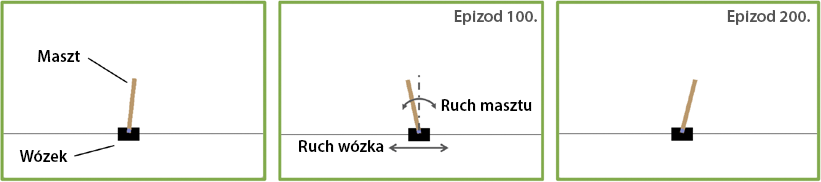

In [7]:
Image(filename='rysunki/18_06.png', width=800)

### Przykład świata blokowego

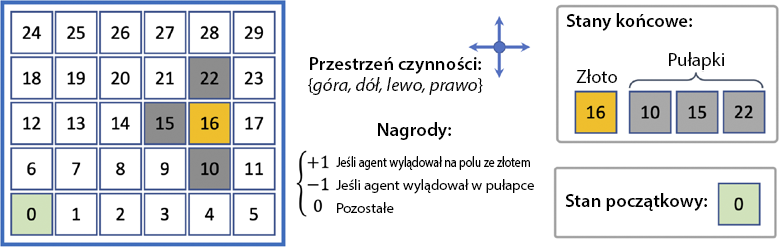

In [8]:
Image(filename='rysunki/18_07.png', width=800)

### Implementacja środowiska świata blokowego w pakiecie OpenAI Gym

```
```

```python
# kodowanie: utf-8

# Python. Uczenie maszynowe. Wydanie III
# Sebastian Raschka (https://sebastianraschka.com) i Vahid Mirjalili](http://vahidmirjalili.com)
# Packt Publishing Ltd. 2019
#
# Repozytorium kodu: https://github.com/rasbt/python-machine-learning-book-3rd-edition
#
# Licencja: MIT License (https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

###############################################################################################################
# Rozdział 18.  Uczenie przez wzmacnianie jako mechanizm podejmowania decyzji w skomplikowanych środowiskach
###############################################################################################################

# Skrypt: srod_swiatblokowy.py

import numpy as np
from gym.envs.toy_text import discrete
from collections import defaultdict
import time
import pickle
import os

from gym.envs.classic_control import rendering

CELL_SIZE = 100
MARGIN = 10


def get_coords(row, col, loc='center'):
    xc = (col + 1.5) * CELL_SIZE
    yc = (row + 1.5) * CELL_SIZE
    if loc == 'center':
        return xc, yc
    elif loc == 'interior_corners':
        half_size = CELL_SIZE//2 - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = xc - half_size, xc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE//3
        x2, y2 = xc + CELL_SIZE//3, yc - CELL_SIZE//3
        x3, y3 = xc - CELL_SIZE//3, yc - CELL_SIZE//3
        return [(x1, y1), (x2, y2), (x3, y3)]


def draw_object(coords_list):
    if len(coords_list) == 1:  # -> kółko
        obj = rendering.make_circle(int(0.45*CELL_SIZE))
        obj_transform = rendering.Transform()
        obj.add_attr(obj_transform)
        obj_transform.set_translation(*coords_list[0])
        obj.set_color(0.2, 0.2, 0.2)  # -> czarne
    elif len(coords_list) == 3:  # -> trójkąt
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.9, 0.6, 0.2)  # -> żółty
    elif len(coords_list) > 3:  # -> wielokąt
        obj = rendering.FilledPolygon(coords_list)
        obj.set_color(0.4, 0.4, 0.8)  # -> niebieski
    return obj


class GridWorldEnv(discrete.DiscreteEnv):
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
        self.num_rows = num_rows
        self.num_cols = num_cols

        self.delay = delay

        move_up = lambda row, col: (max(row - 1, 0), col)
        move_down = lambda row, col: (min(row + 1, num_rows - 1), col)
        move_left = lambda row, col: (row, max(col - 1, 0))
        move_right = lambda row, col: (row, min(col + 1, num_cols - 1))

        self.action_defs = {0: move_up, 1: move_right,
                            2: move_down, 3: move_left}

        # Liczba stanów/czynności
        nS = num_cols * num_rows
        nA = len(self.action_defs)
        self.grid2state_dict = {(s // num_cols, s % num_cols): s
                                for s in range(nS)}
        self.state2grid_dict = {s: (s // num_cols, s % num_cols)
                                for s in range(nS)}

        # Stan ze złotem
        gold_cell = (num_rows // 2, num_cols - 2)

        # Stany z pułapkami
        trap_cells = [((gold_cell[0] + 1), gold_cell[1]),
                      (gold_cell[0], gold_cell[1] - 1),
                      ((gold_cell[0] - 1), gold_cell[1])]

        gold_state = self.grid2state_dict[gold_cell]
        trap_states = [self.grid2state_dict[(r, c)]
                       for (r, c) in trap_cells]
        self.terminal_states = [gold_state] + trap_states
        print(self.terminal_states)

        # Wyznacza prawdopodobieństwa przejścia 
        P = defaultdict(dict)
        for s in range(nS):
            row, col = self.state2grid_dict[s]
            P[s] = defaultdict(list)
            for a in range(nA):
                action = self.action_defs[a]
                next_s = self.grid2state_dict[action(row, col)]

                # Stan końcowy
                if self.is_terminal(next_s):
                    r = (1.0 if next_s == self.terminal_states[0]
                         else -1.0)
                else:
                    r = 0.0
                if self.is_terminal(s):
                    done = True
                    next_s = s
                else:
                    done = False
                P[s][a] = [(1.0, next_s, r, done)]

        # Początkowy rozkład stanów
        isd = np.zeros(nS)
        isd[0] = 1.0

        super(GridWorldEnv, self).__init__(nS, nA, P, isd)

        self.viewer = None
        self._build_display(gold_cell, trap_cells)

    def is_terminal(self, state):
        return state in self.terminal_states

    def _build_display(self, gold_cell, trap_cells):

        screen_width = (self.num_cols + 2) * CELL_SIZE
        screen_height = (self.num_rows + 2) * CELL_SIZE
        self.viewer = rendering.Viewer(screen_width,
                                       screen_height)

        all_objects = []

        # Lista współrzędnych punktów granicznych
        bp_list = [
            (CELL_SIZE - MARGIN, CELL_SIZE - MARGIN),
            (screen_width - CELL_SIZE + MARGIN, CELL_SIZE - MARGIN),
            (screen_width - CELL_SIZE + MARGIN,
             screen_height - CELL_SIZE + MARGIN),
            (CELL_SIZE - MARGIN, screen_height - CELL_SIZE + MARGIN)
        ]
        border = rendering.PolyLine(bp_list, True)
        border.set_linewidth(5)
        all_objects.append(border)

        # Linie pionowe
        for col in range(self.num_cols + 1):
            x1, y1 = (col + 1) * CELL_SIZE, CELL_SIZE
            x2, y2 = (col + 1) * CELL_SIZE, \
                     (self.num_rows + 1) * CELL_SIZE
            line = rendering.PolyLine([(x1, y1), (x2, y2)], False)
            all_objects.append(line)

        # Linie poziome
        for row in range(self.num_rows + 1):
            x1, y1 = CELL_SIZE, (row + 1) * CELL_SIZE
            x2, y2 = (self.num_cols + 1) * CELL_SIZE, \
                     (row + 1) * CELL_SIZE
            line = rendering.PolyLine([(x1, y1), (x2, y2)], False)
            all_objects.append(line)

        # Pułapki: --> kółka
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            all_objects.append(draw_object([trap_coords]))

        # Złoto:  --> trójkąt
        gold_coords = get_coords(*gold_cell,
                                 loc='interior_triangle')
        all_objects.append(draw_object(gold_coords))

        # Agent --> kwadrat lub robot
        if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE == 100):
            agent_coords = pickle.load(
                open('robot-coordinates.pkl', 'rb'))
            starting_coords = get_coords(0, 0, loc='center')
            agent_coords += np.array(starting_coords)
        else:
            agent_coords = get_coords(0, 0, loc='interior_corners')
        agent = draw_object(agent_coords)
        self.agent_trans = rendering.Transform()
        agent.add_attr(self.agent_trans)
        all_objects.append(agent)

        for obj in all_objects:
            self.viewer.add_geom(obj)

    def render(self, mode='human', done=False):
        if done:
            sleep_time = 1
        else:
            sleep_time = self.delay
        x_coord = self.s % self.num_cols
        y_coord = self.s // self.num_cols
        x_coord = (x_coord + 0) * CELL_SIZE
        y_coord = (y_coord + 0) * CELL_SIZE
        self.agent_trans.set_translation(x_coord, y_coord)
        rend = self.viewer.render(
            return_rgb_array=(mode == 'rgb_array'))
        time.sleep(sleep_time)
        return rend

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


if __name__ == '__main__':
    env = GridWorldEnv(5, 6)
    for i in range(1):
        s = env.reset()
        env.render(mode='human', done=False)

        while True:
            action = np.random.choice(env.nA)
            res = env.step(action)
            print('Czynność ', env.s, action, ' -> ', res)
            env.render(mode='human', done=res[2])
            if res[2]:
                break

    env.close()
    
```

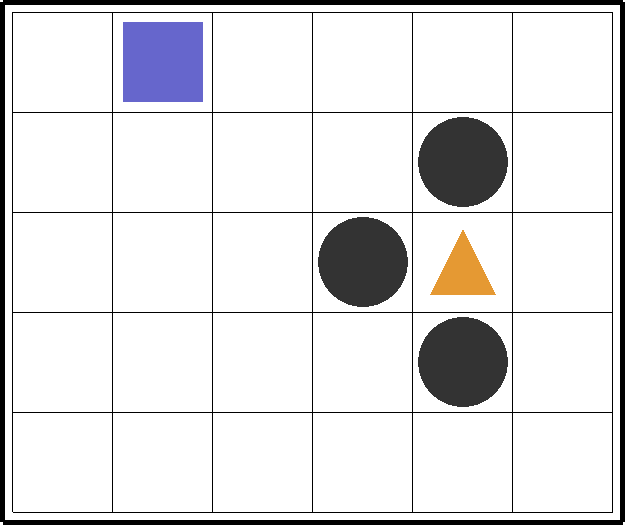

In [9]:
Image(filename='rysunki/18_08.png', width=600)

## Rozwiązywanie problemu świata blokowego za pomocą Q-uczenia

### Implementacja algorytmu Q-uczenia



```python
# kodowanie: utf-8

# Python. Uczenie maszynowe. Wydanie III
# Sebastian Raschka (https://sebastianraschka.com) i Vahid Mirjalili](http://vahidmirjalili.com)
# Packt Publishing Ltd. 2019
#
# Repozytorium kodu: https://github.com/rasbt/python-machine-learning-book-3rd-edition
#
# Licencja: MIT License (https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

###############################################################################################################
# Rozdział 18.  Uczenie przez wzmacnianie jako mechanizm podejmowania decyzji w skomplikowanych środowiskach
###############################################################################################################

# Skrypt: agent.py

from collections import defaultdict
import numpy as np


class Agent(object):
    def __init__(
            self, env,
            learning_rate=0.01,
            discount_factor=0.9,
            epsilon_greedy=0.9,
            epsilon_min=0.1,
            epsilon_decay=0.95):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Definiuje obiekt q_table
        self.q_table = defaultdict(lambda: np.zeros(self.env.nA))

    def choose_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.env.nA)
        else:
            q_vals = self.q_table[state]
            perm_actions = np.random.permutation(self.env.nA)
            q_vals = [q_vals[a] for a in perm_actions]
            perm_q_argmax = np.argmax(q_vals)
            action = perm_actions[perm_q_argmax]
        return action

    def _learn(self, transition):
        s, a, r, next_s, done = transition
        q_val = self.q_table[s][a]
        if done:
            q_target = r
        else:
            q_target = r + self.gamma*np.max(self.q_table[next_s])

        # Aktualizuje obiekt q_table
        self.q_table[s][a] += self.lr * (q_target - q_val)

        # Koryguje epsilon
        self._adjust_epsilon()

    def _adjust_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

```

```python
# kodowanie: utf-8

# Python. Uczenie maszynowe. Wydanie III
# Sebastian Raschka (https://sebastianraschka.com) i Vahid Mirjalili](http://vahidmirjalili.com)
# Packt Publishing Ltd. 2019
#
# Repozytorium kodu: https://github.com/rasbt/python-machine-learning-book-3rd-edition
#
# Licencja: MIT License (https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

###############################################################################################################
# Rozdział 18.  Uczenie przez wzmacnianie jako mechanizm podejmowania decyzji w skomplikowanych środowiskach
###############################################################################################################

# Skrypt: quczenie.py

from gridworld_env import GridWorldEnv
from agent import Agent
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

Transition = namedtuple(
    'Transition', ('state', 'action', 'reward', 'next_state', 'done'))


def run_qlearning(agent, env, num_episodes=50):
    history = []
    for episode in range(num_episodes):
        state = env.reset()
        env.render(mode='human')
        final_reward, n_moves = 0.0, 0
        while True:
            action = agent.choose_action(state)
            next_s, reward, done, _ = env.step(action)
            agent._learn(Transition(state, action, reward,
                                    next_s, done))
            env.render(mode='human', done=done)
            state = next_s
            n_moves += 1
            if done:
                break
            final_reward = reward
        history.append((n_moves, final_reward))
        print('Epizod %d.: Nagroda: %.1f Liczba ruchów %d'
              % (episode, final_reward, n_moves))

    return history


def plot_learning_history(history):
    fig = plt.figure(1, figsize=(14, 10))
    ax = fig.add_subplot(2, 1, 1)
    episodes = np.arange(len(history))
    moves = np.array([h[0] for h in history])
    plt.plot(episodes, moves, lw=4,
             marker="o", markersize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Epizody', size=20)
    plt.ylabel('Liczba ruchó', size=20)

    ax = fig.add_subplot(2, 1, 2)
    rewards = np.array([h[1] for h in history])
    plt.step(episodes, rewards, lw=4)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Epizody', size=20)
    plt.ylabel('Nagrody końcowe', size=20)
    plt.savefig('q-uczenie-historia.png', dpi=300)
    plt.show()


if __name__ == '__main__':
    env = GridWorldEnv(num_rows=5, num_cols=6)
    agent = Agent(env)
    history = run_qlearning(agent, env)
    env.close()

    plot_learning_history(history)


```

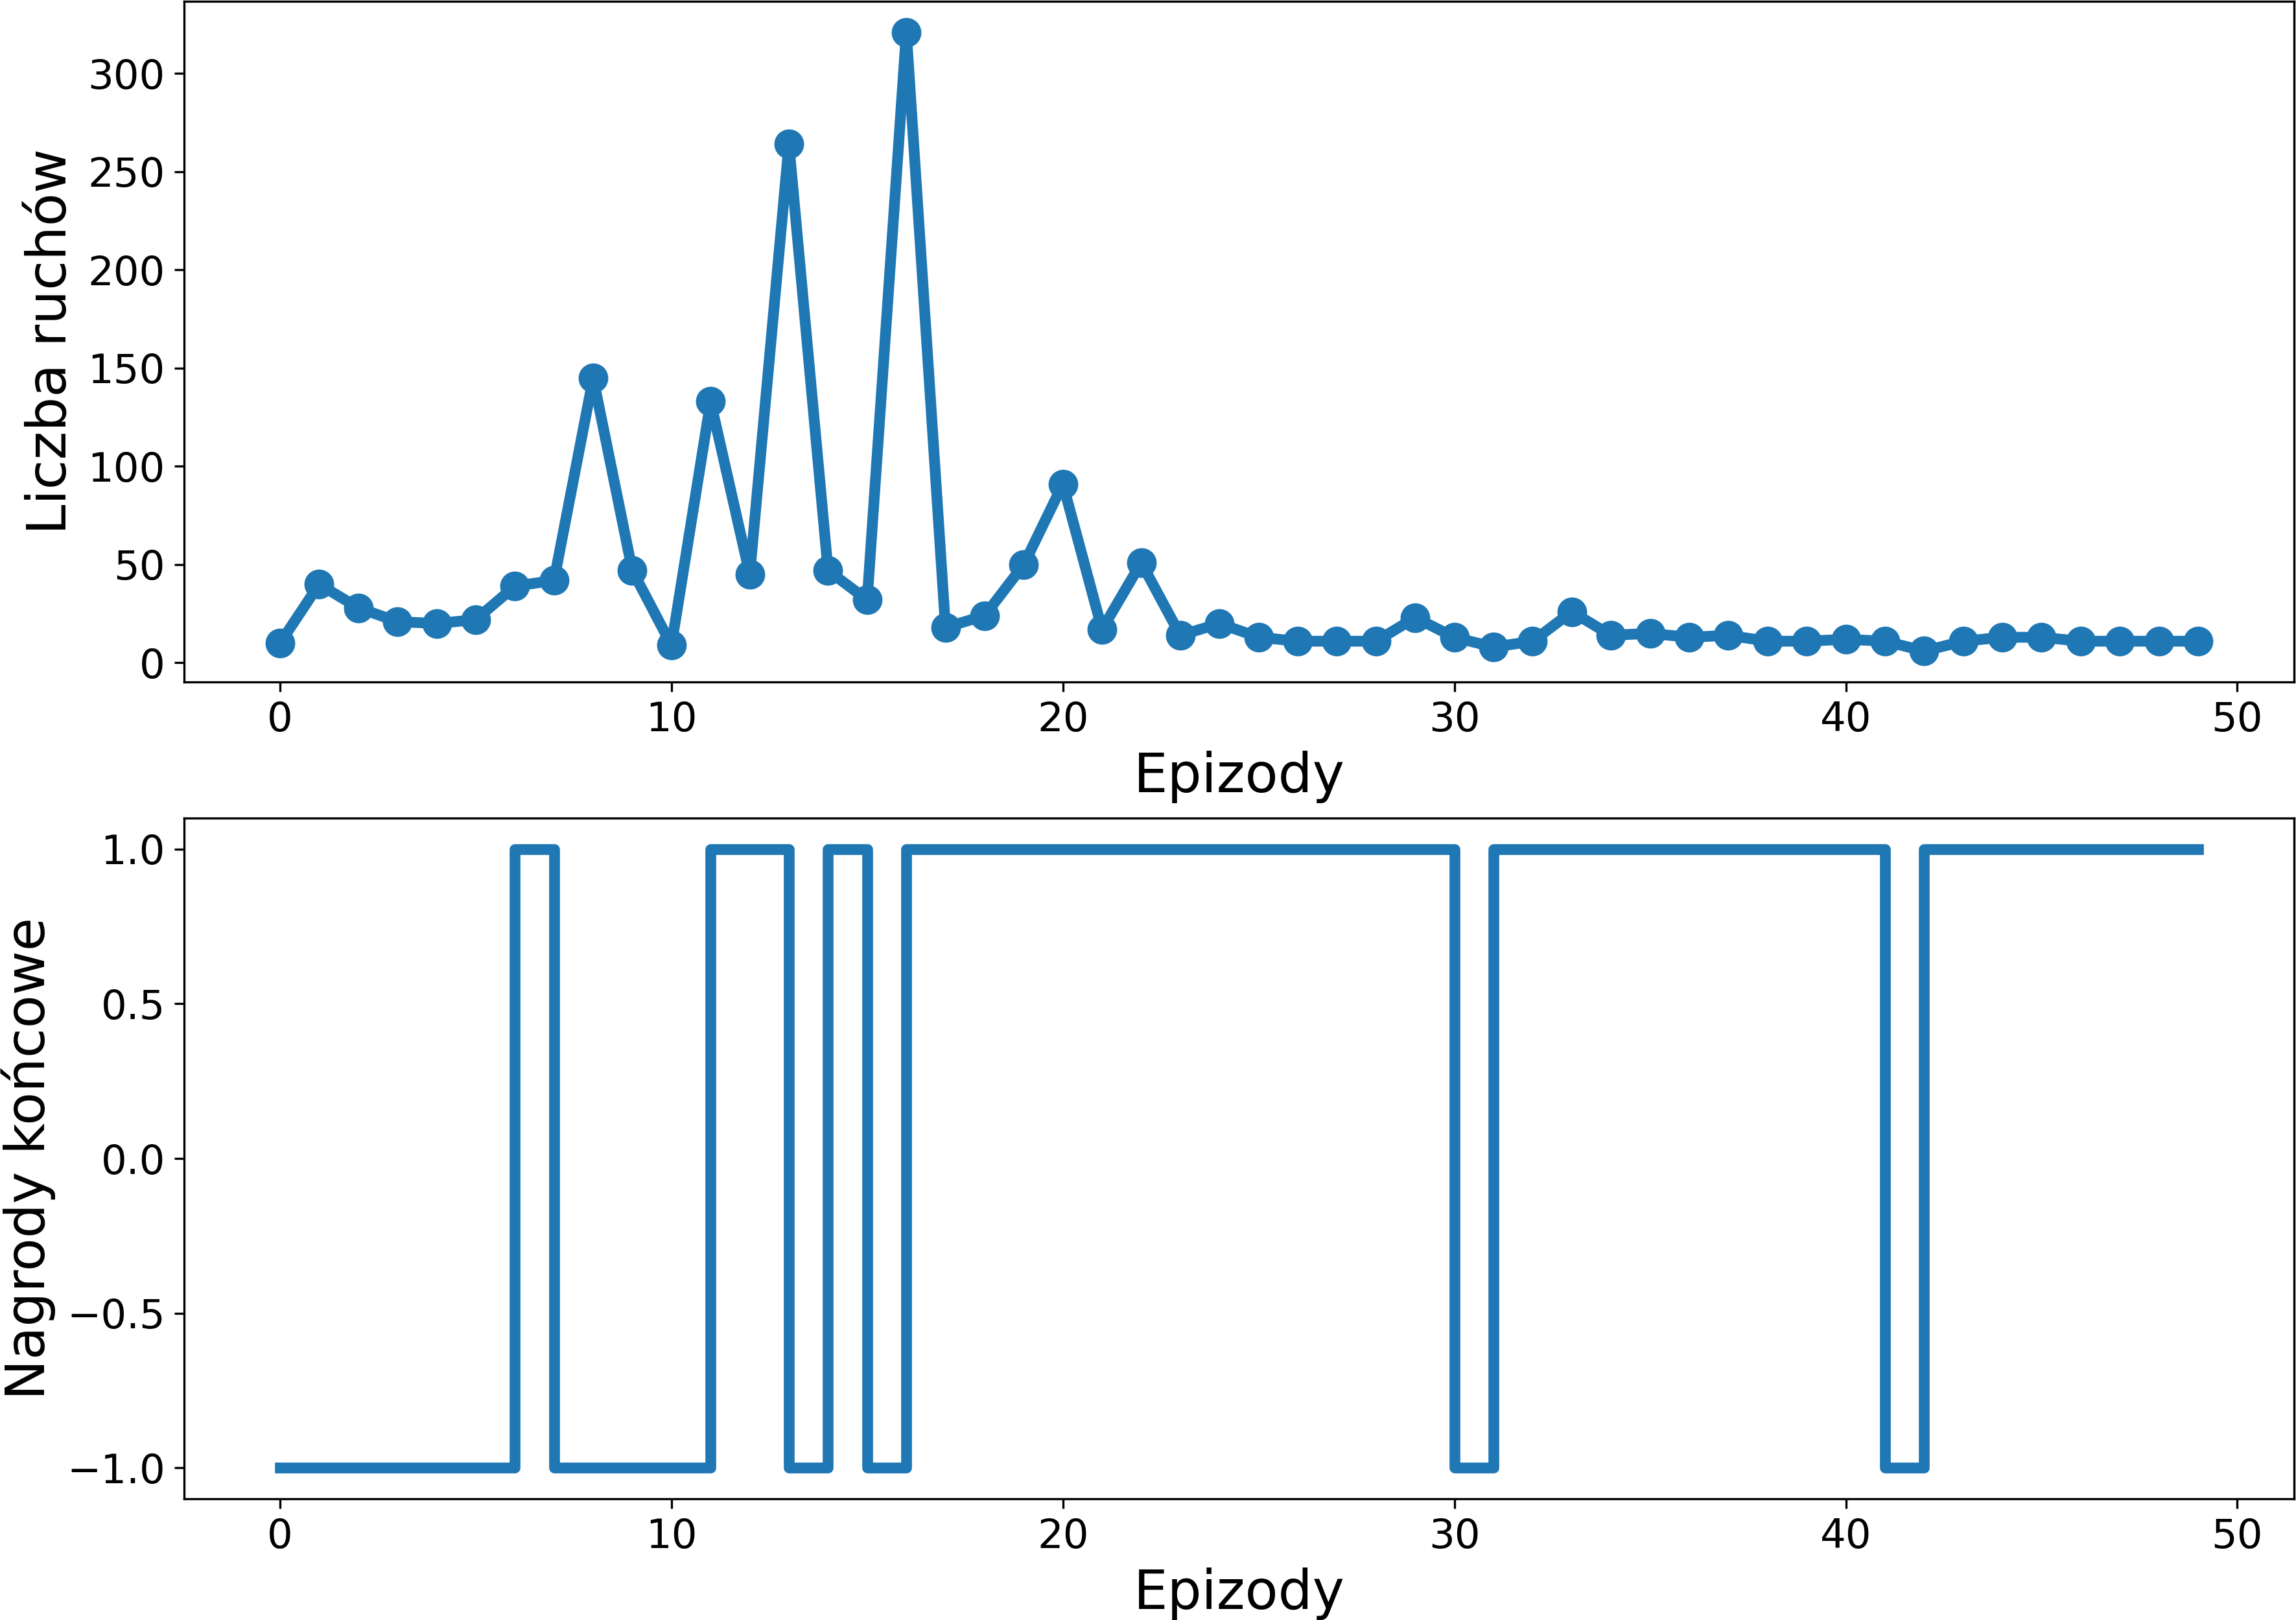

In [10]:
Image(filename='rysunki/18_proj1.png', width=800)

## Krótko o algorytmie Q-uczenia głębokiego

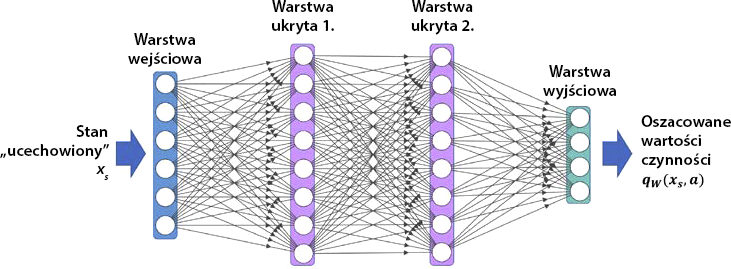

In [11]:
Image(filename='rysunki/18_09.png', width=800)

### Trenowanie modelu DQN za pomocą algorytmu Q-uczenia

#### Pamięć odtwarzania



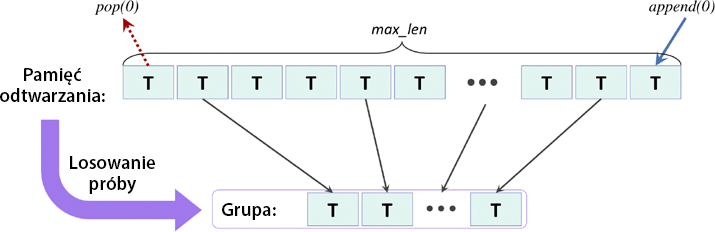

In [12]:
Image(filename='rysunki/18_10.png', width=800)

#### Określanie wartości docelowych potrzebnych do obliczania funkcji straty



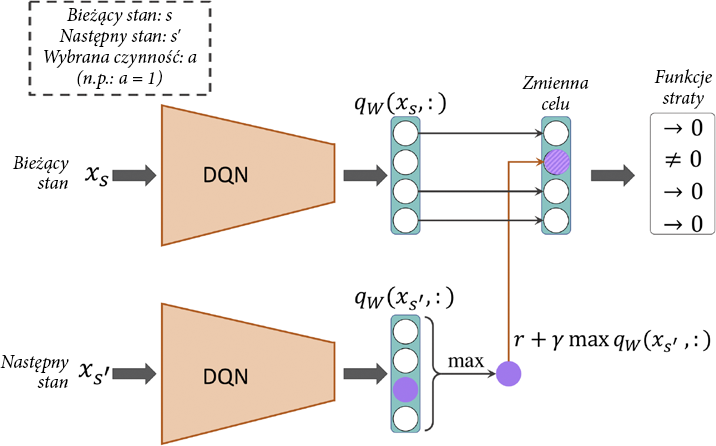

In [13]:
Image(filename='rysunki/18_11.png', width=800)

## Implementacja algorytmu Q-uczenia głębokiego


```python

# kodowanie: utf-8

# Python. Uczenie maszynowe. Wydanie III
# Sebastian Raschka (https://sebastianraschka.com) i Vahid Mirjalili](http://vahidmirjalili.com)
# Packt Publishing Ltd. 2019
#
# Repozytorium kodu: https://github.com/rasbt/python-machine-learning-book-3rd-edition
#
# Licencja: MIT License (https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

###############################################################################################################
# Rozdział 18.  Uczenie przez wzmacnianie jako mechanizm podejmowania decyzji w skomplikowanych środowiskach
###############################################################################################################

# Skrypt: carpole/main.py

import gym
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque

np.random.seed(1)
tf.random.set_seed(1)

Transition = namedtuple(
    'Transition', ('state', 'action', 'reward',
                   'next_state', 'done'))


class DQNAgent:
    def __init__(
            self, env, discount_factor=0.95,
            epsilon_greedy=1.0, epsilon_min=0.01,
            epsilon_decay=0.995, learning_rate=1e-3,
            max_memory_size=2000):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        self.memory = deque(maxlen=max_memory_size)

        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = learning_rate
        self._build_nn_model()

    def _build_nn_model(self, n_layers=3):
        self.model = tf.keras.Sequential()

        # Warstwy ukryte
        for n in range(n_layers - 1):
            self.model.add(tf.keras.layers.Dense(
                units=32, activation='relu'))
            self.model.add(tf.keras.layers.Dense(
                units=32, activation='relu'))

        # Ostatnia warstwa
        self.model.add(tf.keras.layers.Dense(
            units=self.action_size))

        # Tworzy i kompiluje model
        self.model.build(input_shape=(None, self.state_size))
        self.model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(lr=self.lr))

    def remember(self, transition):
        self.memory.append(transition)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)[0]
        return np.argmax(q_values)  # zwraca czynność

    def _learn(self, batch_samples):
        batch_states, batch_targets = [], []
        for transition in batch_samples:
            s, a, r, next_s, done = transition
            if done:
                target = r
            else:
                target = (r +
                          self.gamma * np.amax(
                            self.model.predict(next_s)[0]
                            )
                          )
            target_all = self.model.predict(s)[0]
            target_all[a] = target
            batch_states.append(s.flatten())
            batch_targets.append(target_all)
            self._adjust_epsilon()
        return self.model.fit(x=np.array(batch_states),
                              y=np.array(batch_targets),
                              epochs=1,
                              verbose=0)

    def _adjust_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        history = self._learn(samples)
        return history.history['loss'][0]


def plot_learning_history(history):
    fig = plt.figure(1, figsize=(14, 5))
    ax = fig.add_subplot(1, 1, 1)
    episodes = np.arange(len(history[0])) + 1
    plt.plot(episodes, history[0], lw=4,
             marker='o', markersize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Epizody', size=20)
    plt.ylabel('Całkowita liczba nagród', size=20)
    plt.show()


# Ustawienia ogólne
EPISODES = 200
batch_size = 32
init_replay_memory_size = 500

if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    agent = DQNAgent(env)
    state = env.reset()
    state = np.reshape(state, [1, agent.state_size])

    # Wypełnianie pamięci odtwarzania
    for i in range(init_replay_memory_size):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, agent.state_size])
        agent.remember(Transition(state, action, reward,
                                  next_state, done))
        if done:
            state = env.reset()
            state = np.reshape(state, [1, agent.state_size])
        else:
            state = next_state

    total_rewards, losses = [], []
    for e in range(EPISODES):
        state = env.reset()
        if e % 10 == 0:
            env.render()
        state = np.reshape(state, [1, agent.state_size])
        for i in range(500):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state,
                                    [1, agent.state_size])
            agent.remember(Transition(state, action, reward,
                                      next_state, done))
            state = next_state
            if e % 10 == 0:
                env.render()
            if done:
                total_rewards.append(i)
                print('Epizod: %d/%d, Nagroda całkowita: %d'
                      % (e, EPISODES, i))
                break
            loss = agent.replay(batch_size)
            losses.append(loss)
    plot_learning_history(total_rewards)

```

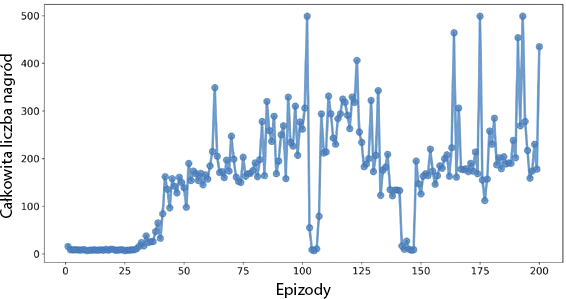

In [14]:
Image(filename='rysunki/18_proj2.png', width=800)


...


# Podsumowanie rozdziału i książki


...

